2023-12-14 14:32:50.715527: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/usr/lib/nvidia
2023-12-14 14:32:50.715556: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


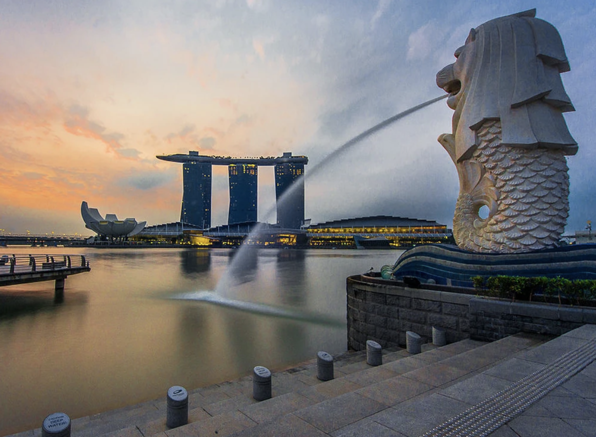

2023-12-14 14:32:57.903 | INFO     | lavis.models:load_model_and_preprocess:152 - Loading the preprocessors from the default config file...
2023-12-14 14:32:57.903 | INFO     | lavis.models:load_model_and_preprocess:153 - args:{'model': {'arch': 'blip_image_text_matching', 'load_finetuned': True, 'finetuned': 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_retrieval_coco.pth', 'vit_type': 'large', 'vit_grad_ckpt': False, 'vit_ckpt_layer': 0, 'image_size': 384, 'med_config_path': 'configs/models/med_large_config.json', 'embed_dim': 256}, 'preprocess': {'vis_processor': {'eval': {'name': 'blip_image_eval', 'image_size': 384}}, 'text_processor': {'eval': {'name': 'blip_caption'}}}}
2023-12-14 14:32:57.904 | INFO     | lavis.models:load_preprocess:96 - Visual pretrained model: {'eval': {'name': 'blip_image_eval', 'image_size': 384}} | Text pretrained model: {'eval': {'name': 'blip_caption'}}


In [1]:
import torch
from PIL import Image

from lavis.models import load_model_and_preprocess
from lavis.processors import load_processor
raw_image = Image.open("./merlion.png").convert("RGB")
display(raw_image.resize((596, 437)))
# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
caption = "Merlion near marina bay."
# model, vis_processors, text_processors = load_model_and_preprocess("blip_image_text_matching", "base", device=device, is_eval=True)
model, vis_processors, text_processors = load_model_and_preprocess("blip_image_text_matching", "large", device=device, is_eval=True)

from matplotlib import pyplot as plt
from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam
import numpy as np

dst_w = 720
w, h = raw_image.size
scaling_factor = dst_w / w

resized_img = raw_image.resize((int(w * scaling_factor), int(h * scaling_factor)))
norm_img = np.float32(resized_img) / 255

img = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
txt = text_processors["eval"](caption)



#### GradCam for each token

In [3]:
txt_tokens = model.tokenizer(txt, return_tensors="pt").to(device)
gradcam, _ = compute_gradcam(model, img, txt, txt_tokens, block_num=7)
avg_gradcam = getAttMap(norm_img, gradcam[0][1], blur=True)
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
ax[0,0].imshow(img)
ax[0,1].imshow(avg_gradcam)

num_image = len(txt_tokens.input_ids[0]) - 2
fig, ax = plt.subplots(num_image, 1, figsize=(15, 5 * num_image))

gradcam_iter = iter(gradcam[0][2:-1])
token_id_iter = iter(txt_tokens.input_ids[0][1:-1])

for i, (gradcam, token_id) in enumerate(zip(gradcam_iter, token_id_iter)):
    row = i // 2
    col = i % 2
    word = model.tokenizer.decode([token_id])
    gradcam_image = getAttMap(norm_img, gradcam, blur=True)
    ax[row, col].imshow(gradcam_image)
    ax[row, col].set_yticks([])
    ax[row, col].set_xticks([])
    ax[row, col].set_xlabel(word)
    
    

OutOfMemoryError: CUDA out of memory. Tried to allocate 22.00 MiB. GPU 0 has a total capacty of 5.80 GiB of which 11.44 MiB is free. Including non-PyTorch memory, this process has 5.78 GiB memory in use. Of the allocated memory 4.31 GiB is allocated by PyTorch, and 278.10 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF